## Nanopore RNA
Author: Robert Ietswaart, 20201007  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.
Python v3.7.4, pytorch v1.4 

For Erik's project: perform nascent RNA modelling based on Nanopore 3' end sequencing.

source file: `RNAdecay_fitting.ipynb`

In [39]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from gtfparse import read_gtf
import seaborn as sns
from scipy.stats import linregress
# from scipy.stats import beta
# import new_total_ratio as ntr
# import aic

In [2]:
path = os.path.join('/n','groups','churchman','ri23','RNAdecay','files_from_local_analyses')
filename = 'SEM2_read_ends_coordinates.txt'
nano3prime = pd.read_csv(os.path.join(path,filename), sep='\t') 

filename = 'SEM2_mito_read_to_transcript_mapping_no_spliced_reads.txt'
genes = pd.read_csv(os.path.join(path,filename), sep='\t') 

filename = 'Hela_h_MT_MTmod.gtf'


# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column
gtf = read_gtf(os.path.join(path,filename)) 

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version']


In [3]:
len(nano3prime)#.head()
nano3prime

,chrom,start,end,name,score,strand
0,h_MT,150,151,65db5e37-22a3-4dc2-b2e9-c30187ebd393,60,+
1,h_MT,167,168,f932378f-3739-4193-87b8-4ca3644de76b,60,+
2,h_MT,0,1,547cf7c0-1b09-42ec-967f-cadc8cc2f6a7,60,-
3,h_MT,0,1,14ba805f-a6c5-420d-9efb-b5ad94543293,32,-
4,h_MT,0,1,4c9934d5-1267-4420-b15e-0ca01a077ab9,60,-
...,...,...,...,...,...,...
18307,h_MT,16395,16396,47019d5e-7f2c-475f-85ec-e282058086b0,60,-
18308,h_MT,16396,16397,40a2d25b-f71b-4c62-adc9-330166375b9b,6,-
18309,h_MT,16424,16425,914170e1-62cc-4473-8146-64462fba8cb8,60,-
18310,h_MT,16425,16426,417e3da3-c35a-4b97-a8db-a5839e82a308,32,-


In [4]:
genes

,read,number_genes,gene_names,strand,softclip_5prime,softclip_3prime,condition
0,ec15a049-7086-482b-88f6-cebac3a7086f,2,"MT-RNR1,MT-TF",+,135,13,total RNA
1,35408d4d-7625-4f95-b19e-b86133a808a7,2,"MT-RNR1,MT-TF",+,0,158,total RNA
2,ffa6f401-778c-464a-bb53-ca869383c881,2,"MT-RNR1,MT-TF",+,0,17,total RNA
3,694f6b43-debd-4522-a0dd-209e0c0e32f9,2,"MT-RNR1,MT-TF",+,0,5,total RNA
4,dd9739bb-8dde-4353-b276-dda6aa892ac4,2,"MT-RNR1,MT-TF",+,0,4,total RNA
...,...,...,...,...,...,...,...
18007,c4e60a95-d8fc-4b80-b7ae-1f5a75b3694e,1,MT-antiCYB,-,92,8,total RNA
18008,e81e846d-62aa-4029-87a3-f92e5fc9ac22,1,MT-CYB,+,0,4,total RNA
18009,556c936d-45a4-42a1-9ea4-5662ed05d7af,1,MT-antiCYB,-,1,10,total RNA
18010,afa78668-66b5-4c58-8b5f-d02d01852140,1,MT-CYB,+,0,73,total RNA


In [5]:
gtf.columns

Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_version', 'transcript_id',
       'transcript_version', 'gene_name', 'gene_source', 'gene_biotype',
       'transcript_name', 'transcript_source', 'transcript_biotype', 'tag',
       'transcript_support_level', 'exon_number', 'exon_id', 'exon_version',
       'protein_id', 'protein_version'],
      dtype='object')

In [6]:
gtf

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,transcript_name,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version
0,h_MT,ensembl,transcript,408,409,NaN,-,0,LSP,1,...,LSP,ensembl,LSP,basic,NA,,,,,
1,h_MT,ensembl,transcript,560,561,NaN,+,0,HSP1,1,...,HSP1,ensembl,HSP1,basic,NA,,,,,
2,h_MT,ensembl,transcript,645,646,NaN,+,0,HSP2,1,...,HSP2,ensembl,HSP2,basic,NA,,,,,
3,h_MT,insdc,gene,577,647,NaN,+,0,ENSG00000210049,1,...,,,,,,,,,,
4,h_MT,ensembl,transcript,577,647,NaN,+,0,ENSG00000210049,1,...,MT-TF-201,ensembl,Mt_tRNA,basic,NA,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,h_MT,ensembl,transcript,15887,15951,NaN,+,0,ENSG00000210195,2,...,MT-TT-201,ensembl,Mt_tRNA,basic,NA,,,,,
159,h_MT,ensembl,exon,15887,15951,NaN,+,0,ENSG00000210195,2,...,MT-TT-201,ensembl,Mt_tRNA,basic,NA,1,ENSE00001544475,2,,
160,h_MT,insdc,gene,15954,16021,NaN,-,0,ENSG00000210196,2,...,,,,,,,,,,
161,h_MT,ensembl,transcript,15954,16021,NaN,-,0,ENSG00000210196,2,...,MT-TP-201,ensembl,Mt_tRNA,basic,NA,,,,,


### Load Erik's half life estimates with Timelapse-seq modeling
See basecamp message: https://3.basecamp.com/4998421/buckets/21055454/todos/3867646250

In [7]:
# |   | 500uM_Rep1  | 50uM_Rep1  | 50uM_Rep2
# | MT-RNR2  |   | 1097.85161  | 829.145648
# | MT-ND1  | 37.772955  | 29.333612  | 20.146311
# | MT-ND2  | 41.726748  | 37.819438  | 21.620602
# | MT-CO1  | 149.990861  | 145.075159  | 115.350696
# | MT-CO2  | 114.382986  | 113.311911  | 85.226305
# | MT-ATP8-6  | 121.435681  | 121.859394  | 87.959691
# | MT-CO3  | 118.000711  | 105.209622  | 82.75348
# | MT-ND3  | 47.159375  | 51.581479  | 23.916938
# | MT-ND4L-4  | 111.409567  | 102.202509  | 76.054483
# | MT-ND5  | 67.489514  | 63.801643  | 44.801687
# | MT-CYB  | 71.03519  | 61.427459  | 39.203985

#Nanostrings flow through
#      | mt-rnr1  | 580.8
#      | mt-rnr2  | 717.4


deg_rate = pd.DataFrame()
deg_rate['symbol'] = ['MT-RNR1', 'MT-RNR2', 'MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2',
                      'MT-ATP8-6', 'MT-CO3', 'MT-ND3', 'MT-ND4L-4', 'MT-ND5', 'MT-CYB']
deg_rate['rep1_500uM'] = [580.8, 717.4, 37.772955, 41.726748, 149.990861, 114.382986,
                          121.435681, 118.000711, 47.159375, 111.409567, 67.489514, 71.03519]
deg_rate['rep1_50uM'] = [800, 1097.85161, 29.333612, 37.819438, 145.075159, 113.311911,
                         121.859394, 105.209622, 51.581479, 102.202509, 63.801643, 61.427459]
deg_rate['rep2_50uM'] = [580.8, 829.145648, 20.146311, 21.620602, 115.350696, 85.226305, 
                         87.959691, 82.75348, 23.916938, 76.054483, 44.801687, 39.203985]
deg_rate['average'] = (deg_rate['rep1_500uM'] + deg_rate['rep1_50uM'] + deg_rate['rep2_50uM']) / 3

#convert half lifes to degradation rates: 
deg_rate['rep1_500uM'] = (np.log(2) * deg_rate['rep1_500uM'])**(-1)
deg_rate['rep1_50uM'] = (np.log(2) * deg_rate['rep1_50uM'])**(-1)
deg_rate['rep2_50uM'] = (np.log(2) * deg_rate['rep2_50uM'])**(-1)
deg_rate['average'] = (np.log(2) * deg_rate['average'])**(-1)

outpath = os.path.join('/n','groups','churchman','ri23','RNAdecay')
filename = 'TLseq_degradation_rates.csv'
# deg_rate.to_csv(os.path.join(outpath,filename))

### Generate Nanopore coverage from 3' end

In [9]:
genome_len = max(max(nano3prime['end']), max(gtf['end']))
window_3p = 50
TSS = gtf[gtf['gene_id']=='HSP2']['end'].values[0]
gen_loc = np.arange(genome_len)
rna = np.zeros(genome_len) #plus strand only

In [10]:
genes_of_interest = set(deg_rate['symbol'])

for idx in nano3prime.index:#[:1]:
    if nano3prime['strand'][idx] == '+':
        end = nano3prime['end'][idx]
        read_id = nano3prime['name'][idx]#get read id.
        g_info = genes[genes['read']==read_id]
        if len(g_info) > 0:
            mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
            mapping_genes = set(mapping_genes.split(','))
            gene_oi = mapping_genes.intersection(genes_of_interest)
            nascent = True
            for g in gene_oi:
                g_info = gtf[gtf['gene_name']==g]
                g5p = g_info['start'].values[0]
                g3p = g_info['end'].values[0]
#                 print(g, g5p, g3p, end)
                
                if abs(g3p - end) <= window_3p:#mature RNA
                    rna[g5p:(end+1)] += 1 #add coverage only over that gene: 
                    nascent = False
#                     print('mature RNA')
                    continue
            if nascent: #nascent RNA:
                rna[TSS:(end+1)] += 1

### Generate model predicted RNA
Assumption Pol II elongates across whole genome and does not drop off

In [11]:
#Firing rate F not known in absolute terms, use RNR1 or ND1 to estimate from 
#observed Nanopore + degradation rate
rep = 'average' #'rep1_50uM'#
g = 'MT-RNR1' #'MT-CYB'#
end = gtf[gtf['gene_name']==g]['end'].values[0]
print(g,'3\'end', end)

F = rna[(end-window_3p)] * deg_rate[deg_rate['symbol']==g][rep].values[0] 
print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F)
#wil be used to scale model to observed RNA which are all relative values.

velo = 3.81 * 60 #3.81 ± 0.37 nt/s converted to nt/min

rna_model = np.zeros(genome_len)
for x in range(TSS,genome_len):
    rna_model[x] += F * (genome_len - x) / velo

for idx in deg_rate.index:
    g = deg_rate['symbol'][idx]
    deg = deg_rate[rep][idx]
    g_info = gtf[gtf['gene_name']==g]
    g5p = g_info['start'].values[0]
    g3p = g_info['end'].values[0]
    print(g, g5p, g3p)
    
    rna_model[g5p:g3p] += F / deg
    print(F, deg, F/deg)

MT-RNR1 3'end 1601
Relative firing rate (min^-1), fitted using gene  MT-RNR1 :  16.56128004217867
MT-RNR1 648 1601
16.56128004217867 0.0022064055478522074 7506.0
MT-RNR2 1671 3228
16.56128004217867 0.0016367000493489735 10118.701987432707
MT-ND1 3304 4261
16.56128004217867 0.049603923926347625 333.8703620860522
MT-ND2 4469 5510
16.56128004217867 0.042781679721480226 387.11149608890713
MT-CO1 5900 7444
16.56128004217867 0.01054558684853102 1570.4465081035887
MT-CO2 7585 8290
16.56128004217867 0.013831230018945442 1197.383025189641
MT-ATP8-6 8364 9206
16.56128004217867 0.013065729362719238 1267.5358246309136
MT-CO3 9206 9989
16.56128004217867 0.014145741877870018 1170.7607975010194
MT-ND3 10058 10403
16.56128004217867 0.035285855485372594 469.3461392495921
MT-ND4L-4 10469 12136
16.56128004217867 0.01494161127058816 1108.3998734981647
MT-ND5 12336 14740
16.56128004217867 0.024578427063548874 673.8136659176183
MT-CYB 14746 15886
16.56128004217867 0.025212151143284435 656.876914153752


## Plot nanopore RNA

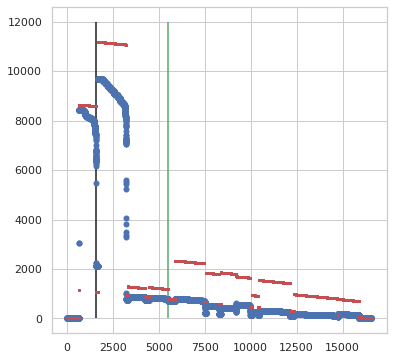

In [12]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc, y=rna, 
            fmt='o', ms=5,color='b') 

ax.errorbar(x=gen_loc, y=rna_model, 
            fmt='o', ms=2,color='r') 

g = 'MT-RNR1' #'MT-RNR2'#
end = gtf[gtf['gene_name']==g]['end'].values[0]
plt.vlines(end,ymin=0,ymax=1.2e4)

g = 'MT-ND2' #'MT-RNR2'#
end = gtf[gtf['gene_name']==g]['end'].values[0]
plt.vlines(end,ymin=0,ymax=1.2e4, color='g')

(-100.0, 2000.0)

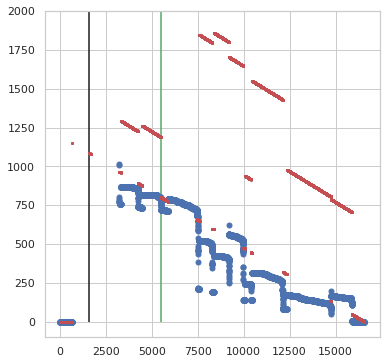

In [13]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc, y=rna, 
            fmt='o', ms=5,color='b') 

ax.errorbar(x=gen_loc, y=rna_model, 
            fmt='o', ms=2,color='r') 

g = 'MT-RNR1' #'MT-RNR2'#
end = gtf[gtf['gene_name']==g]['end'].values[0]
plt.vlines(end,ymin=0,ymax=1.2e4)

g = 'MT-ND2' #'MT-RNR2'#
end = gtf[gtf['gene_name']==g]['end'].values[0]
plt.vlines(end,ymin=0,ymax=1.2e4, color='g')

plt.ylim([-100,2000])

### Fit range of possible elongation rates
"Nascent" RNA:= total RNA - 3' mapping RNA

In [34]:
nrna = np.zeros(genome_len) #plus strand only

window_3p = 100

for idx in nano3prime.index:#[:1]:
    if nano3prime['strand'][idx] == '+':
        end = nano3prime['end'][idx]
        read_id = nano3prime['name'][idx]#get read id.
        g_info = genes[genes['read']==read_id]
        if len(g_info) > 0:
            mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
            mapping_genes = set(mapping_genes.split(','))
            gene_oi = mapping_genes.intersection(genes_of_interest)
            nascent = True
            for g in gene_oi:
                g_info = gtf[gtf['gene_name']==g]
                g5p = max(g_info['start'].values)
                g3p = max(g_info['end'].values)
                
                if abs(g3p - end) <= window_3p:#mature RNA
                    nascent = False
                    continue
            if nascent: #nascent RNA:
                nrna[TSS:(end+1)] += 1

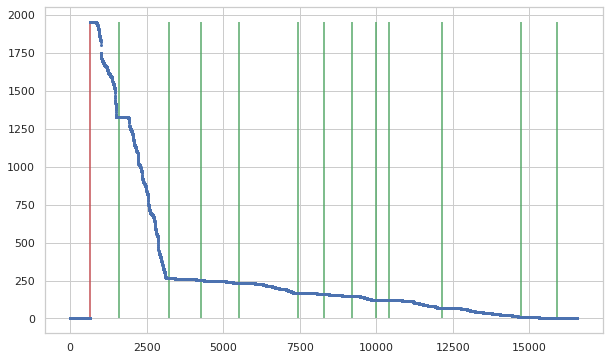

In [35]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(10, 6))          

ax.errorbar(x=gen_loc, y=nrna, 
            fmt='o', ms=2,color='b') 

# ax.errorbar(x=gen_loc, y=rna_model, 
#             fmt='o', ms=2,color='r') 

loc_start = gtf[gtf['gene_name']=='MT-RNR1']['start'].values[0]
plt.vlines(loc_start,ymin=0,ymax=max(nrna), color='r')

for g in genes_of_interest:
    end = max(gtf[gtf['gene_name']==g]['end'].values)
    plt.vlines(end,ymin=0,ymax=max(nrna), color='g')

In [49]:
fit_start = gtf[gtf['gene_name']=='MT-RNR1']['start'].values[0]
fit_end = max(gtf[gtf['gene_name']=='MT-RNR2']['end'].values)
print('RNRs range',fit_start, fit_end)
gen_loc_rnrs = gen_loc[fit_start:fit_end]

res_rnrs = linregress(gen_loc_rnrs, nrna[fit_start:fit_end])
print(res_rnrs)
fit_rnrs = res_rnrs.slope * gen_loc_rnrs + res_rnrs.intercept

fit_start = max(gtf[gtf['gene_name']=='MT-RNR2']['end'].values)
fit_end = max(gtf[gtf['gene_name'].isin(genes_of_interest)]['end'].values)
print('mRNAs range',fit_start, fit_end)
gen_loc_mrna = gen_loc[fit_start:fit_end]

res_mrna = linregress(gen_loc_mrna, nrna[fit_start:fit_end])
print(res_mrna)
fit_mrna = res_mrna.slope * gen_loc_mrna + res_mrna.intercept


RNRs range 648 3228
LinregressResult(slope=-0.6814841090295917, intercept=2497.137089151811, rvalue=-0.9919585865613896, pvalue=0.0, stderr=0.0017124862138020811, intercept_stderr=3.554638851091479)
mRNAs range 3228 15886
LinregressResult(slope=-0.022796202646332073, intercept=352.8312122171018, rvalue=-0.9963484331778347, pvalue=0.0, stderr=1.736444198385148e-05, intercept_stderr=0.17766019817915182)


In [74]:
velo_rnrs = F / abs(res_rnrs.slope) #nt/s
print(velo_rnrs, 'nt/s', velo_rnrs * 60 / 1000, 'kb/min')

24.301784623798966 nt/s 1.4581070774279379 kb/min


In [75]:
velo_mrna = F / abs(res_mrna.slope) #nt/s
print(velo_mrna, 'nt/s', velo_mrna * 60 / 1000, 'kb/min')

726.4929295074236 nt/s 43.589575770445414 kb/min


<ErrorbarContainer object of 3 artists>

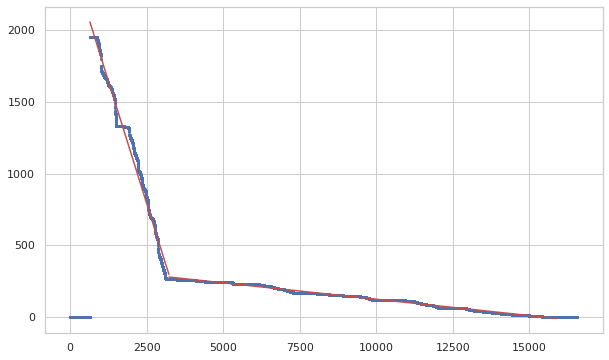

In [53]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(10, 6))          

ax.errorbar(x=gen_loc, y=nrna, 
            fmt='o', ms=2,color='b') 

ax.errorbar(x=gen_loc_rnrs, y=fit_rnrs, 
            fmt='-', ms=1,color='r')

ax.errorbar(x=gen_loc_mrna, y=fit_mrna, 
            fmt='-', ms=1,color='r')

## Testing effect of assumed mRNA region specific transcription initiation rate

In [90]:
#Firing rate F not known in absolute terms, use MT-CYB to estimate from 
#observed Nanopore + degradation rate
rep = 'average' #'rep1_50uM'#
g = 'MT-CYB'#

end = gtf[gtf['gene_name']==g]['end'].values[0]
print(g,'3\'end', end)

F_mrna = rna[(end-window_3p)] * deg_rate[deg_rate['symbol']==g][rep].values[0] 
print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F_mrna)
#wil be used to scale model to observed RNA which are all relative values.


MT-CYB 3'end 15886
Relative firing rate (min^-1), fitted using gene  MT-CYB :  3.8574591249225185


In [91]:
velo_mrna = F_mrna / abs(res_mrna.slope) #nt/s
print(velo_mrna, 'nt/s', velo_mrna * 60 / 1000, 'kb/min')

169.2149865821265 nt/s 10.15289919492759 kb/min
